### Import dữ liệu

In [17]:
import numpy as np 
import matplotlib.pyplot as plt
import warnings
import random
import os
import cv2

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNetV2

### Đọc dữ liệu

In [3]:
# path = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
path = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset" # đường dẫn đến thư mục chứa dữ liệu
classes = [i for i in os.listdir(path) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [4]:
data = [] # mảng chứa dữ liệu
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data.append([img, folder])

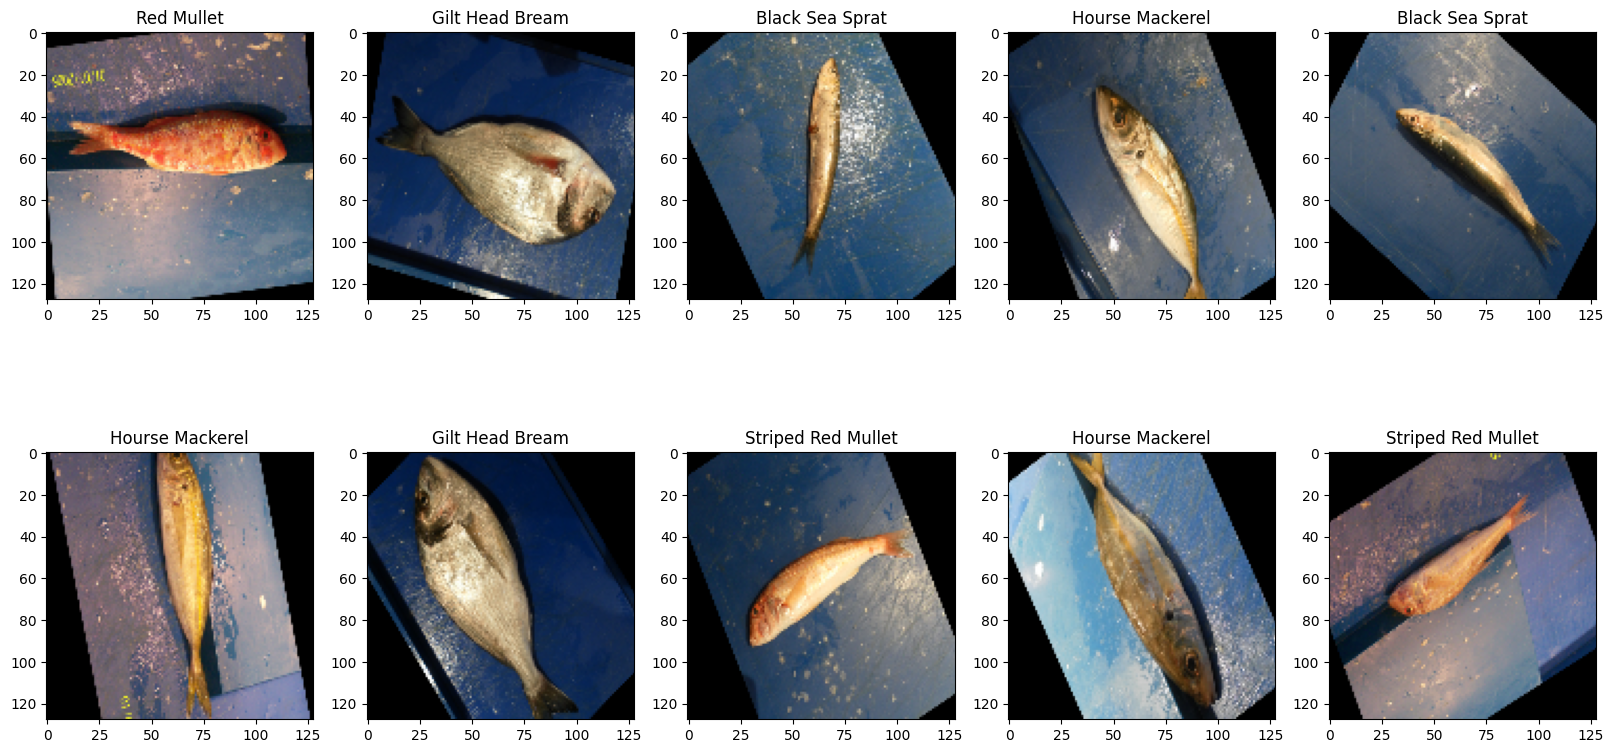

In [5]:
# hiện thị một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 8990)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [6]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [7]:
# chuấn hóa label thành dạng số
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [8]:
# chuyển images thành numpy array và chuẩn hóa về khoảng [0, 1]
images = np.array(images)
images = images.astype('float32') / 255.0
images.shape

(9000, 128, 128, 3)

In [18]:
# shuffle dữ liệu
random.shuffle(images)

### Trích xuất đặc trưng

In [19]:
pre_trained= MobileNetV2(include_top=False, pooling='avg', input_shape=(128, 128, 3))

In [20]:
# Lấy đặc trưng từ pre-trained model
features = pre_trained.predict(images)

282/282 [==============================] - 73s 254ms/step


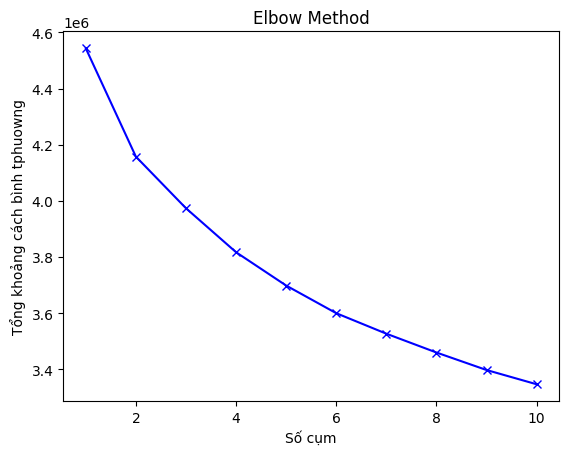

In [21]:
warnings.filterwarnings("ignore")

# Khởi tạo một mảng lưu distortion cho mỗi số lượng cụm
distortions = []

# Thử các số lượng cụm từ 1 đến k_max
k_max = 10
for k in range(1, k_max+1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    distortions.append(kmeans.inertia_)

# Vẽ đồ thị elbow
plt.plot(range(1, k_max+1), distortions, 'bx-')
plt.xlabel('Số cụm')
plt.ylabel('Tổng khoảng cách bình tphuowng')
plt.title('Elbow Method')
plt.show()

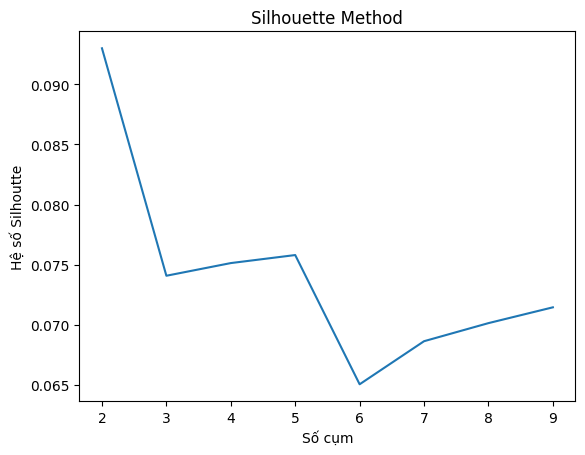

In [22]:
warnings.filterwarnings("ignore")

scores = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(features)
    scores.append(silhouette_score(features, kmeans.labels_))

plt.plot(range(2, 10), scores)
plt.xlabel('Số cụm')
plt.ylabel('Hệ số Silhoutte')
plt.title('Silhouette Method')
plt.show()

In [43]:
# Áp dụng K-means để phân cụm
kmeans =  KMeans ( n_clusters = 9 , init = 'k-means++' , n_init = 1 , max_iter = 1000 , tol = 0.0001 , verbose = 0 , random_state = None , copy_x = True , algorithm = "lloyd" )
clusters = kmeans.fit_predict(features)

In [44]:
# xác định vị trí các ảnh là tâm của các cluster
center_id = []
for i in range(9):
    center_id.append(np.where(clusters == i)[0][0])
center_id

[2577, 18, 0, 1, 1058, 1083, 19, 222, 3111]

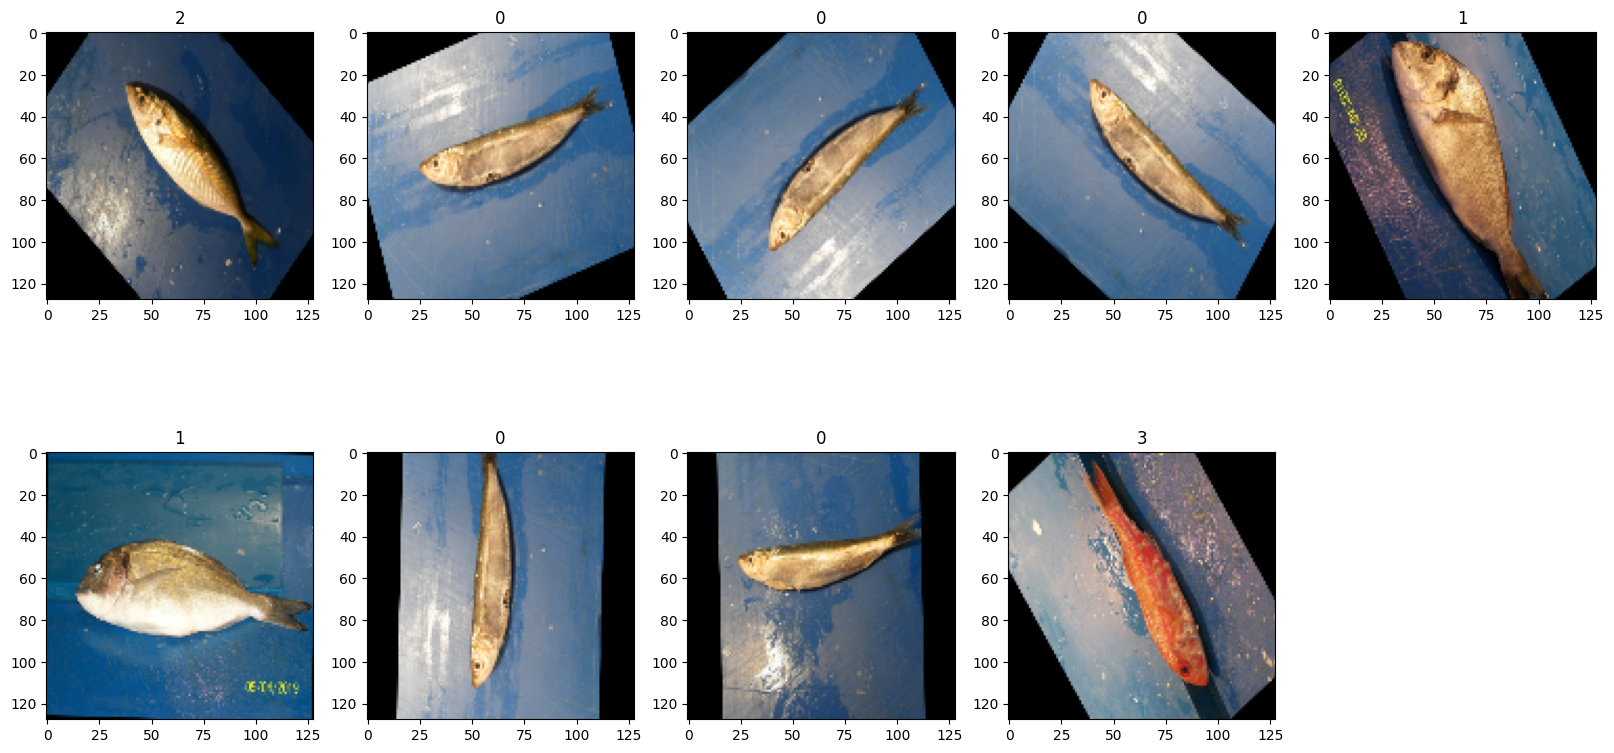

In [45]:
# in ra các ảnh là tâm của các cluster
plt.figure(figsize=(20, 10))
for i in range(9):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[center_id[i]].reshape(128, 128, 3))
    # plt.title(i)
    plt.title(labels[center_id[i]])

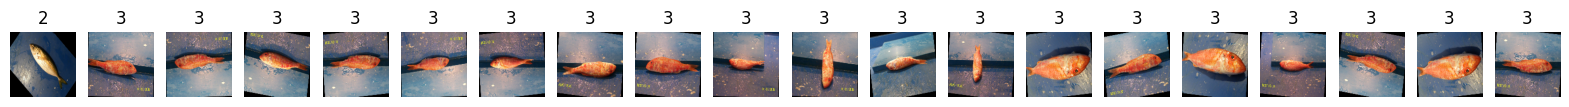

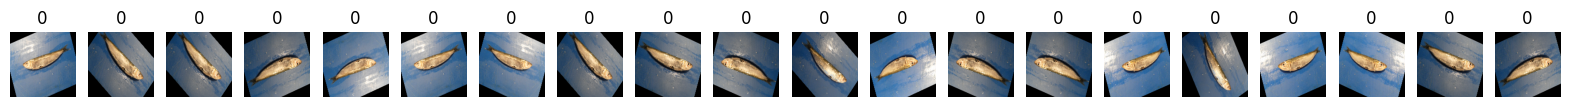

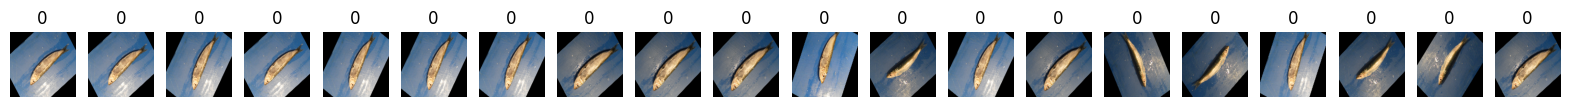

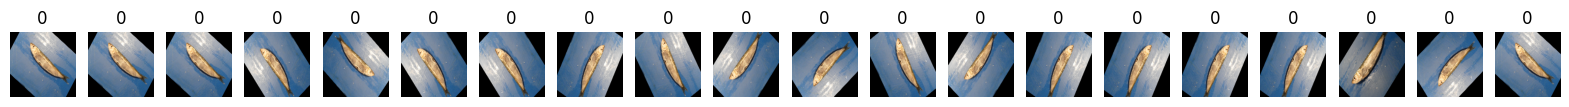

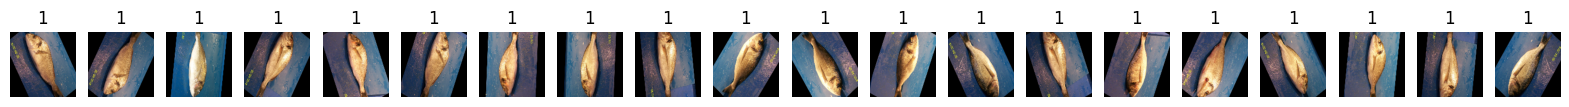

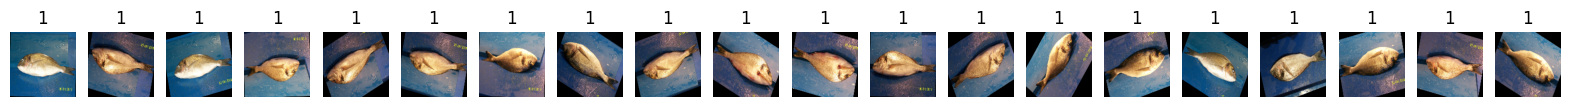

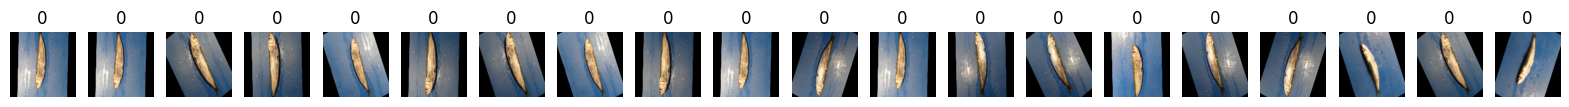

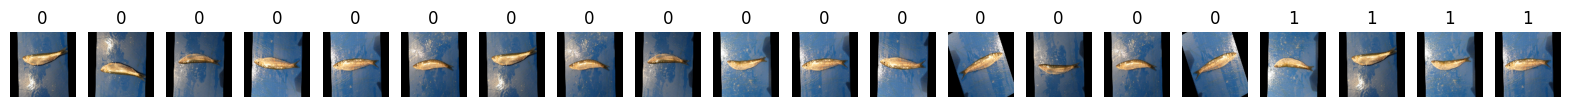

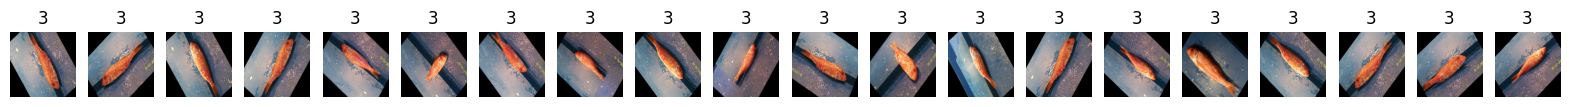

In [46]:
import matplotlib.pyplot as plt

# Reshape cluster centers to match image dimensions
cluster_centers = np.array(kmeans.cluster_centers_)

num_clusters = cluster_centers.shape[0]
images_per_row = 20

# Display clusters
for cluster_id in range(num_clusters):
    cluster_center = cluster_centers[cluster_id]

    # Create a new row for each cluster
    plt.figure(figsize=(20, 1))

    # Plot the cluster center as the first image in the row
    plt.subplot(1, images_per_row + 1, 1)
    plt.imshow(images[cluster_id].reshape(128,128,3))
    plt.title(labels[cluster_id])
    plt.axis('off')

    # Get indices of images in the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]

    # Plot the images in the cluster
    for i, img_idx in enumerate(cluster_indices[:images_per_row]):
        img = images[img_idx]
        plt.subplot(1, images_per_row, i+1)
        plt.imshow(img.reshape(128,128,3))
        plt.title(labels[img_idx])
        plt.axis('off')

    plt.show()